# Simulator

This notebook goes over the basic usage of the simulator class interface to running some basic simulations of a Smoluchowski eqution, and shows how you can extend the functionality to work for a new system by defining a force function.

After going through this notebook you should understan how to perform the following tasks using this package:
- Initialize an instance of the FPE simulator class by defining a configuration dictionary
- Run a simulation of the model system for a fixed amount of time in a static environment
- Run a simulation of the model system in a dynamic environment
- Define a new, custom model, and use the simulator interface to run the model

In [1]:
# Import necessary requirements
import numpy as np
from fokker_planck.simulator.simulator import HarmonicEquilibrationSimulator, BreathingSimulator
from fokker_planck.types.basetypes import BoundaryCondition
import fokker_planck.forceFunctions as ff

# Define the required configuration for the system, we will look at a domain of
# -2 -> +2 with a discretization of 0.01 in space and 0.001 in time
config = {
    "D": 1.0,
    "dx": 0.01,
    "dt": 0.00025,
    "x_min": -2.0,
    "x_max": 2.0,
    "boundary_cond": BoundaryCondition.HardWall
}

# An alternate, but equivalent configuration would specify, instead of x_min
# and x_max, the range of x values directly:
config_alt = {
    "D": 1.0,
    "dx": 0.01,
    "dt": 0.00025,
    "x_array": np.arange(-2, 2, 0.01),
    "boundary_cond": BoundaryCondition.HardWall
}


In [2]:
# Now we can initialize the simulator class with the configuration as well
# as a few parameters that are intended to be used for dynamic potentials

harmonic_sim = HarmonicEquilibrationSimulator(config, k_trap=8.0)
harmonic_sim.initialize_probability(mean=-0.25, init_var=1/32)

# And then run the simulation
sim_result = harmonic_sim.run_simulation(tau=0.5)

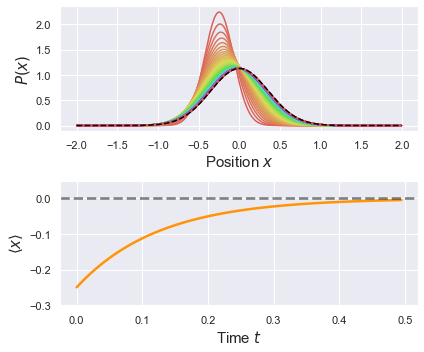

In [3]:
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
plot_dir = Path().resolve().parents[1] / 'figures' / 'reports'
sns.set(style='darkgrid', palette='hls')

fig, ax = plt.subplots(2, 1, figsize=(6, 5))

Pal = sns.color_palette('hls', len(sim_result.prob_tracker[::20]))

mean_tracker = []
norm_tracker = []

# Calcualte the mean value of the distribution over time
for i, prob in enumerate(sim_result.prob_tracker[::20]):
    ax[0].plot(sim_result._sim.fpe.x_array, prob, color=Pal[i], linewidth=1.5)
    _mean = np.sum(sim_result._sim.fpe.x_array * prob) * sim_result._sim.fpe.dx
    mean_tracker.append(_mean)
    norm_tracker.append(np.sum(prob) * sim_result._sim.fpe.dx)

time_range = np.arange(0, 0.5, config['dt'])

# Calcualte the theoretical equilibrium distribution of the syste,
eq_dist = np.exp(-0.5 * 8.0 * (sim_result._sim.fpe.x_array) ** 2)
eq_dist = eq_dist / np.sum(eq_dist * sim_result._sim.fpe.dx)

# Plot the mean over time
ax[1].plot(sim_result.time[::20], mean_tracker, color=sns.xkcd_rgb['tangerine'], linewidth=2.5)
ax[1].set_ylim([-0.3, 0.05])
ax[1].axhline(0, linestyle='--', linewidth=2.5, color='k', alpha=0.5)
ax[0].plot(sim_result._sim.fpe.x_array, eq_dist, color='k', linestyle='--')

ax[0].set_xlabel(r'Position $x$', fontsize=15)
ax[0].set_ylabel(r'$P(x)$', fontsize=15)
ax[1].set_xlabel(r'Time $t$', fontsize=15)
ax[1].set_ylabel(r"$\langle x\rangle$", fontsize=15)
plt.tight_layout()
plt.savefig(plot_dir / 'relaxation_harmonic_sim_ex.pdf')
plt.savefig(plot_dir / 'relaxation_harmonic_sim_ex.png', dpi=600)
plt.show()


In [4]:
# Now lets define a dynamic environment, say a breathing trap

# start with the same config
k_init = 10.0
k_final = 4.0

breath_sim = BreathingSimulator(
    config, k_init, k_final, force_function=ff.harmonic_force,
    energy_function=ff.harmonic_energy
)

breath_sim.initialize_probability()

breath_res = breath_sim.run_simulation(tau=0.5, mode='naive')

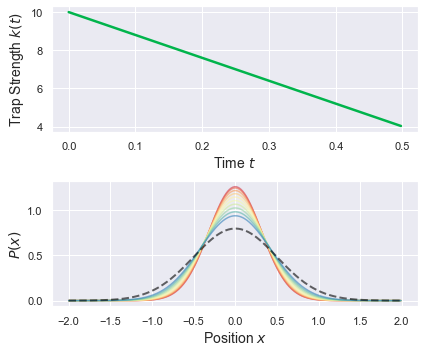

In [5]:
fig, ax = plt.subplots(2, 1, figsize=(6, 5.0))

ax[0].plot(breath_res.time, breath_res.CP, linewidth=2.5, color=sns.xkcd_rgb['shamrock'])
Pal = sns.color_palette('Spectral', len(breath_res.prob_tracker[::20]))

for i, prob in enumerate(breath_res.prob_tracker[::20]):
    ax[1].plot(breath_res.x_array, prob, color=Pal[i], alpha=0.6)

init_eq = np.exp(-0.5 * k_init * (breath_res.x_array ** 2))
fin_eq = np.exp(-0.5 * k_final * (breath_res.x_array ** 2))
init_eq = init_eq / np.sum(init_eq * breath_sim.fpe.dx)
fin_eq = fin_eq / np.sum(fin_eq * breath_sim.fpe.dx)

ax[1].plot(breath_res.x_array, fin_eq, '--', color='k', alpha=0.6, linewidth=2.0)

ax[0].set_ylabel(r"Trap Strength $k(t)$", fontsize=14)
ax[0].set_xlabel(r"Time $t$", fontsize=14)

ax[1].set_xlabel(r"Position $x$", fontsize=14)
ax[1].set_ylabel(r"$P(x)$", fontsize=14)

plt.tight_layout()
plt.savefig(plot_dir / 'breathing_trap_naive.png', dpi=600)
plt.show()

In [7]:
# And then define a simple custom simulator object
from fokker_planck.simulator.simulator import StaticSimulator1D


def multi_period_force(x, params):
    return (
        params[0] * np.sin(2 * np.pi * x)
        + params[1] * np.sin(2 * np.pi * (x - params[2]))
    )


class MultiPeriodicEqulibration(StaticSimulator1D):
    def __init__(
        self, fpe_config: dict, amp_1: float, amp_2: float, phase_shift: float,
        init_var: float = 1/8
    ):
        super().__init__(fpe_config)
        self.force_func = multi_period_force
        self.force_params = [amp_1, amp_2, phase_shift]
        self.init_var = init_var

    def initialize_probability(self):
        self.fpe.initialize_probability(0, self.init_var)


In [8]:
# Now we can build the config dictionary and run a simulation:
config_periodic = {
    "D": 1.0,
    "dx": 0.01,
    "dt": 0.001,
    "x_min": -2.0,
    "x_max": 2.0,
    "boundary_cond": BoundaryCondition.Periodic
}

# And the force parameters
amp_1 = 0.5
amp_2 = 2.0
phase_shift = 0.33

custom_sim = MultiPeriodicEqulibration(
    config_periodic, amp_1, amp_2, phase_shift
)

In [9]:
# And then run the simulation
res_periodic = custom_sim.run_simulation(tau=1.0)

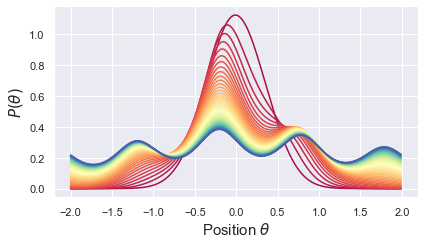

In [10]:
# And then, we before, we can plot the evolution of this probability over time

fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))

Pal = sns.color_palette('Spectral', len(res_periodic.prob_tracker[::20]))

for i, prob in enumerate(res_periodic.prob_tracker[::20]):
    ax.plot(res_periodic.x_array, prob, color=Pal[i])

ax.set_xlabel(r"Position $\theta$", fontsize=15)
ax.set_ylabel(r"$P(\theta)$", fontsize=15)
plt.tight_layout()
plt.show()
